In [1]:
from boto.s3.connection import S3Connection
import gzip

import matplotlib.pyplot as plt
import numpy as np
import pyart
from copy import deepcopy

import shutil, os
from datetime import timedelta, datetime
import tempfile


%load_ext autoreload
%autoreload 2



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/Users/bdolan/anaconda2/lib/python2.7/site-packages/pyart/config.py:103: UserWarning: 
Loading configuration from PYART_CONFIG enviromental variable failed:
--- START IGNORED TRACEBACK --- 
Traceback (most recent call last):
  File "/Users/bdolan/anaconda2/lib/python2.7/site-packages/pyart/config.py", line 95, in <module>
    load_config(_config_file)
  File "/Users/bdolan/anaconda2/lib/python2.7/site-packages/pyart/config.py", line 78, in load_config
    cfile = imp.load_source('metadata_config', filename)
IOError: [Errno 2] No such file or directory

 --- END IGNORED TRACEBACK ---
Loading default configuration
  warnings.warn(msg)
/Users/bdolan/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [30]:
%matplotlib inline

In [3]:
import matplotlib.colors as colors

def add_field_to_radar_object(field, radar, field_name='FH', units='unitless', 
                              long_name='Hydrometeor ID', standard_name='Hydrometeor ID',
                              dz_field='reflectivity'):
    """
    Adds a newly created field to the Py-ART radar object. If reflectivity is a masked array,
    make the new field masked the same as reflectivity.
    """
    fill_value = -32768
    masked_field = np.ma.asanyarray(field)
    masked_field.mask = masked_field == fill_value
    if hasattr(radar.fields[dz_field]['data'], 'mask'):
        setattr(masked_field, 'mask', 
                np.logical_or(masked_field.mask, radar.fields[dz_field]['data'].mask))
        fill_value = radar.fields[dz_field]['_FillValue']
    field_dict = {'data': masked_field,
                  'units': units,
                  'long_name': long_name,
                  'standard_name': standard_name,
                  '_FillValue': fill_value}
    radar.add_field(field_name, field_dict, replace_existing=True)
    return radar

hid_colors = ['White', 'LightBlue', 'MediumBlue', 'DarkOrange', 'LightPink',
              'Cyan', 'DarkGray', 'Lime', 'Yellow', 'Red', 'Fuchsia']
cmaphid = colors.ListedColormap(hid_colors)

def adjust_fhc_colorbar_for_pyart(cb):
    cb.set_ticks(np.arange(1.4, 10, 0.9))
    cb.ax.set_yticklabels(['Drizzle', 'Rain', 'Ice Crystals', 'Aggregates',
                           'Wet Snow', 'Vertical Ice', 'LD Graupel',
                           'HD Graupel', 'Hail', 'Big Drops'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb



hid_colors_winter = ['White','Fuchsia', 'Purple', 'DodgerBlue', 'Green', 'Yellow',
              'Orange', 'Red']#, 'Lime', 'Yellow', 'Red', 'Fuchsia']
cmaphidwinter = colors.ListedColormap(hid_colors_winter)

def adjust_fhcw_colorbar_for_pyart(cb):
    cb.set_ticks(np.arange(1.4, 7, 0.9))
    cb.ax.set_yticklabels(['IC','Plates', 'Dendrites', 'Aggregates', 'Wet Snow',
                           'Frozen', 'Rain'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb



In [4]:
def nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))


def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation 
    datetime_t : datetime
        desired date time
    """
    
    #First create the query string for the bucket knowing
    #how NOAA and AWS store the data
    
    my_pref = datetime_t.strftime('%Y/%m/%d/') + site
    
    #Connect to the bucket
    
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')
    
    #Get a list of files 
    
    bucket_list = list(bucket.list(prefix = my_pref))
    #print(bucket_list)
    #we are going to create a list of keys and datetimes to allow easy searching
    
    keys = []
    datetimes = []
    
    #populate the list

    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-3]
            fmt = '%Y%m%d_%H%M%S_V06' 
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])
            #print(dt)
        if this_str[-3::] == 'V06': #'LSX20160707_000150_' does not match format '%Y%m%d_%H%M%S_V06'
            #print(this_str)
            #print(this_str[-19::])
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06' 
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])
    
    #function to allow easy searching 
    
    def func(x):
        delta =  x - datetime_t if x > datetime_t else timedelta.max
        return delta
    
    #find the closest available radar to your datetime 
    
    closest_datetime = nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)
    #print(closest_datetime)
    #create a temp file, download radar data to file from S3
    #read into a radar object and return
    
    localfile = tempfile.NamedTemporaryFile()
    keys[index].get_contents_to_filename(localfile.name)
    radar = pyart.io.read(localfile.name)
    return radar

In [5]:
def radar_coords_to_cart(rng, az, ele, debug=False):
    """
    TJL - taken from old Py-ART version
    Calculate Cartesian coordinate from radar coordinates
    Parameters
    ----------
    rng : array
        Distances to the center of the radar gates (bins) in kilometers.
    az : array
        Azimuth angle of the radar in degrees.
    ele : array
        Elevation angle of the radar in degrees.
    Returns
    -------
    x, y, z : array
        Cartesian coordinates in meters from the radar.
    Notes
    -----
    The calculation for Cartesian coordinate is adapted from equations
    2.28(b) and 2.28(c) of Doviak and Zrnic [1]_ assuming a
    standard atmosphere (4/3 Earth's radius model).
    .. math::
        z = \\sqrt{r^2+R^2+r*R*sin(\\theta_e)} - R
        s = R * arcsin(\\frac{r*cos(\\theta_e)}{R+z})
        x = s * sin(\\theta_a)
        y = s * cos(\\theta_a)
    Where r is the distance from the radar to the center of the gate,
    :math:\\theta_a is the azimuth angle, :math:\\theta_e is the
    elevation angle, s is the arc length, and R is the effective radius
    of the earth, taken to be 4/3 the mean radius of earth (6371 km).
    References
    ----------
    .. [1] Doviak and Zrnic, Doppler Radar and Weather Observations, Second
        Edition, 1993, p. 21.
    """
    theta_e = ele * np.pi / 180.0  # elevation angle in radians.
    theta_a = az * np.pi / 180.0  # azimuth angle in radians.
    R = 6371.0 * 1000.0 * 4.0 / 3.0  # effective radius of earth in meters.
    r = rng * 1000.0  # distances to gates in meters.

    z = (r ** 2 + R ** 2 + 2.0 * r * R * np.sin(theta_e)) ** 0.5 - R
    s = R * np.arcsin(r * np.cos(theta_e) / (R + z))  # arc length in m.
    x = s * np.sin(theta_a)
    y = s * np.cos(theta_a)
    return x, y, z


def get_z_from_radar(radar):
    """Input radar object, return z from radar (km, 2D)"""
    azimuth_1D = radar.azimuth['data']
    elevation_1D = radar.elevation['data']
    srange_1D = radar.range['data']
    sr_2d, az_2d = np.meshgrid(srange_1D, azimuth_1D)
    el_2d = np.meshgrid(srange_1D, elevation_1D)[1]
    xx, yy, zz = radar_coords_to_cart(sr_2d/1000.0, az_2d, el_2d)
    return zz + radar.altitude['data']

def check_sounding_for_montonic(sounding):
    """
    So the sounding interpolation doesn't fail, force the sounding to behave
    monotonically so that z always increases. This eliminates data from
    descending balloons.
    """
    snd_T = sounding['temperature'].values  # In old SkewT, was sounding.data
    snd_z = sounding['height'].values/1000. # In old SkewT, was sounding.data
    dummy_z = []
    dummy_T = []
    dummy_z.append(snd_z[0])
    dummy_T.append(snd_T[0])
    for i, height in enumerate(snd_z):
        if i > 0:
            if snd_z[i] > snd_z[i-1]:# and not snd_T.mask[i]:
                dummy_z.append(snd_z[i])
                dummy_T.append(snd_T[i])
    snd_z = np.array(dummy_z)
    snd_T = np.array(dummy_T)
    return snd_T, snd_z

def interpolate_sounding_to_radar(sounding, radar):
    """Takes sounding data and interpolates it to every radar gate."""
    radar_z = radar.gate_z['data']/1000.
    radar_T = None
    snd_T, snd_z = check_sounding_for_montonic(sounding)
    shape = np.shape(radar_z)
    rad_z1d = radar_z.ravel()

    rad_T1d = np.interp(np.ravel(rad_z1d), np.array(snd_z), np.array(snd_T))
    return np.reshape(rad_T1d, shape), radar_z


In [6]:
import RadarConfig
configdat =  RadarConfig.RadarConfig(dz='DZ')

In [7]:
from datetime import datetime as dt
import netCDF4
base_date = "20120208_013200"
fmt = '%Y%m%d_%H%M%S' 
b_d = dt.strptime(base_date, fmt)
radsite='KICT'

radar = get_radar_from_aws(radsite,b_d )

#radar = pyart.io.read_uf('OKU-20100128-154548_HID_sector.ufc_HID_sector.uf',file_field_names=True)




In [8]:
import netCDF4
radar_start_date = netCDF4.num2date(radar.time['data'][0],
                                    radar.time['units'])




; This is a program to run HID on polar-coordinate UF files, which allows for varying melting level with azimuth (10 deg sectors).
; The program makes use of the RSL in IDL TRMM GV library suite.

; Written by Brenda Dolan
; 10 July 2008

; Adapted for winter precipitation by Elizabeth Thompson
; 13 July 2013
; for questions or suggestions, please contact me: liz@atmos.colostate.edu
; work with this program is explained in detail by:

;Adapted to Python by B. Dolan
;October 2018

; Thompson E.J., S.A. Rutledge, B. Dolan, V. Chandrasekar, B. Cheong, submitted May 2013: A dual-polarization 
;	radar hydrometeor classification algorithm for winter precipitation. J. Atmos. Oceanic Technol., submitted.

; Major thing to note is that you'll be using cdf_beta_... and cdf_fhc... programs to run the entire HCA algorithm with this program. 
; There are three steps to this overall HCA process: 1) ML detection: "cold_newml1", 2) below ML: "warm", and 3) above ML: "cold2"
; the first two steps are wavelength-independent. The last is either X,C,or S band as noted in the filename of the program.


In [9]:
#radar = pyart.io.read('SEA20171025_215257_rhi.nc')

In [10]:
def two_panel_plot(radar, sweep=0, var1='reflectivity', vmin1=0, vmax1=65,
                   cmap1='RdYlBu_r', units1='dBZ', var2='DR',
                   vmin2=-5, vmax2=5, cmap2='RdYlBu_r', units2='dB', return_flag=False,
                   xlim=[-150,150], ylim=[-150,150]):
    display = pyart.graph.RadarDisplay(radar)
    fig = plt.figure(figsize=(13,18))
    ax1 = fig.add_subplot(211)
    if radar.scan_type == 'rhi':
        display.plot_rhi(var1, sweep=sweep, vmin=vmin1, vmax=vmax1, cmap=cmap1, 
                         colorbar_label=units1, mask_outside=True)
        display.set_limits(xlim=xlim, ylim=ylim)
        ax2 = fig.add_subplot(212)
        display.plot_rhi(var2, sweep=sweep, vmin=vmin2, vmax=vmax2, cmap=cmap2, 
                         colorbar_label=units2, mask_outside=True)
        display.set_limits(xlim=xlim, ylim=ylim)

    else:
        display.plot_ppi(var1, sweep=sweep, vmin=vmin1, vmax=vmax1, cmap=cmap1, 
                         colorbar_label=units1, mask_outside=True)
        display.set_limits(xlim=xlim, ylim=ylim)
        ax2 = fig.add_subplot(212)
        display.plot_ppi(var2, sweep=sweep, vmin=vmin2, vmax=vmax2, cmap=cmap2, 
                         colorbar_label=units2, mask_outside=True)
        display.set_limits(xlim=xlim, ylim=ylim)
    if return_flag:
        return fig, ax1, ax2, display

In [11]:
print radar.info('compact')

altitude: <ndarray of type: float64 and shape: (1,)>
altitude_agl: None
antenna_transition: None
azimuth: <ndarray of type: float64 and shape: (3960,)>
elevation: <ndarray of type: float32 and shape: (3960,)>
fields:
	differential_phase: <ndarray of type: float32 and shape: (3960, 1832)>
	cross_correlation_ratio: <ndarray of type: float32 and shape: (3960, 1832)>
	spectrum_width: <ndarray of type: float32 and shape: (3960, 1832)>
	reflectivity: <ndarray of type: float32 and shape: (3960, 1832)>
	differential_reflectivity: <ndarray of type: float32 and shape: (3960, 1832)>
	velocity: <ndarray of type: float32 and shape: (3960, 1832)>
fixed_angle: <ndarray of type: float32 and shape: (7,)>
instrument_parameters:
	unambiguous_range: <ndarray of type: float32 and shape: (3960,)>
	nyquist_velocity: <ndarray of type: float32 and shape: (3960,)>
latitude: <ndarray of type: float64 and shape: (1,)>
longitude: <ndarray of type: float64 and shape: (1,)>
nsweeps: 7
ngates: 1832
nrays: 3960
radar_

In [12]:
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize = [13,5])
ax1 = fig.add_subplot(121)

display.plot_ppi('reflectivity', sweep = 0, 
                    vmin = -10, vmax = 70, mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef)
display.set_limits([-120,120],[-120,120])

ax2 = fig.add_subplot(122)
display.plot_ppi('differential_reflectivity', sweep = 0, 
                    vmin = -2, vmax = 4,cmap = configdat.zdr_cmap, mask_outside = False)

# display.plot_ppi('reflectivity', sweep = 0, 
#                     vmin = -10, vmax = 70, mask_outside = False,
#                     cmap = pyart.graph.cm.NWSRef)
# display.set_limits([-120,120],[-120,120])

# ax2 = fig.add_subplot(122)
# display.plot_ppi('ZR', sweep = 6, 
#                     vmin = -2, vmax = 4,cmap = configdat.zdr_cmap, mask_outside = False)
# display.set_limits([-120,120],[-120,120])





In [13]:
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize = [13,5])
ax1 = fig.add_subplot(121)

display.plot_ppi('cross_correlation_ratio', sweep = 0, 
                    vmin = 0.5, vmax = 1, mask_outside = False,
                    cmap = 'Reds')
display.set_limits([-180,180],[-180,180])


ax2 = fig.add_subplot(122)
display.plot_ppi('differential_reflectivity', sweep = 0, 
                    vmin = -2, vmax = 4,cmap = configdat.zdr_cmap, mask_outside = False)

display.set_limits([-180,180],[-180,180])

# display.plot_ppi('RH', sweep = 6, 
#                     vmin = 0.5, vmax = 1, mask_outside = False,
#                     cmap = 'Reds')
# display.set_limits([-180,180],[-180,180])


# ax2 = fig.add_subplot(122)
# display.plot_ppi('KC', sweep = 6, 
#                     vmin = -2, vmax = 4,cmap = configdat.zdr_cmap, mask_outside = False)

# display.set_limits([-180,180],[-180,180])




In [14]:
from csu_radartools import csu_kdp

In [15]:
def extract_unmasked_data(radar, field, bad=-32768):
    """Simplify getting unmasked radar fields from Py-ART"""
    return radar.fields[field]['data'].filled(fill_value=bad)

In [16]:
dzN = extract_unmasked_data(radar, 'reflectivity')
dpN = extract_unmasked_data(radar, 'differential_reflectivity')
# Range needs to be supplied as a variable, and it needs to be the same shape as dzN, etc.
rng2d, az2d = np.meshgrid(radar.range['data'], radar.azimuth['data'])

import time
bt = time.time()
kdN, fdN, sdN = csu_kdp.calc_kdp_bringi(
    dp=dpN, dz=dzN, rng=rng2d/1000.0, thsd=12, gs=250.0, window=5)
print(time.time()-bt, 'seconds to run')
radar = add_field_to_radar_object(kdN, radar, field_name='KDP', units='deg/km', 
                                   long_name='Specific Differential Phase',
                                   standard_name='Specific Differential Phase', 
                                   dz_field='reflectivity')
radar = add_field_to_radar_object(fdN, radar, field_name='FDP', units='deg', 
                                   long_name='Filtered Differential Phase',
                                   standard_name='Filtered Differential Phase', 
                                   dz_field='reflectivity')
radar = add_field_to_radar_object(sdN, radar, field_name='SDP', units='deg', 
                                   long_name='Standard Deviation of Differential Phase',
                                   standard_name='Standard Deviation of Differential Phase', 
                                   dz_field='reflectivity')

(0.3383159637451172, 'seconds to run')


In [17]:
import datetime
def get_sounding(time,station):
    v = 'bad'
    itr = 0
    while v == 'bad' and itr < 13:
        print v,itr
        try:
            sounding = WyomingUpperAir.request_data(time,station)
            print('wahoo, found a matching sounding')
            v = 'good'
        except ValueError:
            print('no data! trying another hour')
            time = time + datetime.timedelta(hours=1)
            itr=itr+1
            print itr
    return sounding,time


In [18]:
# dz = radar.fields['DZQC']['data']
# dr = radar.fields['ZDR2']['data']
# kd = radar.fields['KDP']['data']
# rh = radar.fields['RHOHV2']['data']

dz = radar.fields['reflectivity']['data']
dr = radar.fields['differential_reflectivity']['data']
kd = radar.fields['KDP']['data']
rh = radar.fields['cross_correlation_ratio']['data']


# dz = radar.fields['CZ']['data']
# dr = radar.fields['ZR']['data']-0.45
# kd = radar.fields['KD']['data']
# rh = radar.fields['RH']['data']
#radar.fields['ZR']['data'] = dr





In [19]:
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize = [13,5])
ax1 = fig.add_subplot(121)

display.plot_ppi('reflectivity', sweep = 0, 
                    vmin = -10, vmax = 70, mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef)
display.set_limits([-120,120],[-120,120])

ax2 = fig.add_subplot(122)
display.plot_ppi('differential_reflectivity', sweep = 0, 
                    vmin = -2, vmax = 4,cmap = configdat.zdr_cmap, mask_outside = False)
display.set_limits([-120,120],[-120,120])


# display.plot_ppi('CZ', sweep = 0, 
#                     vmin = -10, vmax = 70, mask_outside = False,
#                     cmap = pyart.graph.cm.NWSRef)
# display.set_limits([-120,120],[-120,120])

# ax2 = fig.add_subplot(122)
# display.plot_ppi('ZR', sweep = 6, 
#                     vmin = -2, vmax = 4,cmap = configdat.zdr_cmap, mask_outside = False)
# display.set_limits([-120,120],[-120,120])




In [20]:
#station = 'OUN'
#station = 'FWD'
station = 'TOP'

In [21]:
import SkewT
from siphon.simplewebservice.wyoming import WyomingUpperAir
print 'test1'
sounding, stime = get_sounding(radar_start_date,station)
stimelast = deepcopy(stime)
# except ValueError as ve:
#     print(ve)
#     station = 'OUN'
#     sounding, stime = get_sounding(base_date,station)
#     stimelast = deepcopy(stime)
# except:
#     pass
radar_T, radar_z = interpolate_sounding_to_radar(sounding, radar)

test1
bad 0
no data! trying another hour
1
bad 1
no data! trying another hour
2
bad 2
no data! trying another hour
3
bad 3
no data! trying another hour
4
bad 4
no data! trying another hour
5
bad 5
no data! trying another hour
6
bad 6
no data! trying another hour
7
bad 7
no data! trying another hour
8
bad 8
no data! trying another hour
9
bad 9
no data! trying another hour
10
bad 10
no data! trying another hour
11
bad 11
wahoo, found a matching sounding


In [22]:
print sounding['temperature'].values

[ -0.5  -1.9  -3.3  -3.7  -4.7  -5.7  -5.8  -5.9  -6.5  -7.1  -7.5  -9.3
 -10.1 -11.6 -13.1 -13.1 -10.1 -10.1  -9.9 -10.4 -10.7 -10.9 -11.  -11.1
 -11.5 -11.7 -11.7 -12.7 -12.9 -14.1 -15.3 -15.4 -15.7 -17.4 -18.1 -19.7
 -24.9 -26.5 -29.2 -29.3 -38.3 -41.9 -42.5 -46.8 -46.9 -48.9 -49.3 -51.7
 -52.1 -52.5 -53.5 -52.9 -53.7 -53.1 -53.9 -54.3 -53.  -51.1 -51.1 -51.1
 -51.1 -50.3 -51.7 -51.1 -51.9 -51.5 -51.5 -52.5 -54.1 -54.1 -54.4 -54.5
 -53.9 -55.5 -55.5 -56.1 -56.7 -57.1 -56.7 -57.5 -59.9 -60.8 -60.9 -60.9
 -59.4 -58.7 -58.9 -59.9 -58.9 -59.1 -60.  -61.  -62.1 -62.5 -60.9 -61.4
 -61.7 -62.  -62.1 -61.8 -61.4 -61.1 -60.6 -59.9 -60.4 -60.8 -61.1 -61.
 -60.6 -59.8 -59.5 -58.8 -58.3 -57.7 -58.  -58.7 -59.  -59.1 -57.8 -57.
 -56.2 -55.9 -55.8 -55.3 -55.3 -55.5 -53.9 -52.8 -52.1 -53.3 -53.5]


In [23]:
# wh0 = np.where(np.isclose(np.abs(sounding.soundingdata['temp']),0.0,atol=1.0))
# #print wh0
# expected_ML = sounding.soundingdata['hght'][wh0[0]][0]/1000.
# print 'Expected Melting Layer:',expected_ML


wh0 = np.where(np.isclose(np.abs(sounding['temperature'].values),0.0,atol=1.0))
#print wh0
expected_ML = np.array(sounding['height'])[wh0[0]][0]/1000.
print 'Expected Melting Layer:',expected_ML

Expected Melting Layer: 0.27


In [24]:
heights = radar.gate_altitude['data']#-14320.

In [25]:
sn =pyart.retrieve.simple_moment_calculations.calculate_snr_from_reflectivity(radar,refl_field='reflectivity',toa=15000.0)

In [26]:
radar.add_field('SN',sn,replace_existing=True)

In [27]:
sn = radar.fields['SN']['data']

In [28]:
print np.ma.min(sn)

-2.6298904


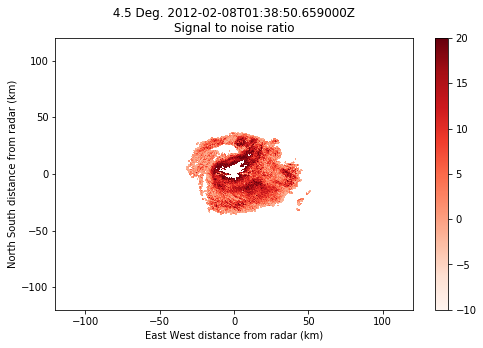

In [31]:
xlim = [-120,120]
ylim = [-120,120]
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(8,5))
display.plot_ppi('SN', sweep=6, vmin=-10, vmax=20, cmap='Reds', 
                 colorbar_label='', mask_outside=True)
display.set_limits(xlim=xlim, ylim=ylim)

In [32]:
from csu_winter import run_winter

In [33]:
types = np.arange(4,6,1)
for c in types:
    print c

4
5


In [34]:
azimuths = radar.azimuth['data']

In [35]:
radsub = radar.extract_sweeps([1])

In [36]:
rhsub = radsub.fields['cross_correlation_ratio']['data']

In [37]:
type(rh)

numpy.ma.core.MaskedArray

In [38]:
print np.shape(rh)
print np.shape(dz)


(3960, 1832)
(3960, 1832)


In [63]:
hcawinter,scores,hca,meltlev = run_winter(dz=dz,zdr=dr,kdp=kd,rho=rh,sn=sn,T=radar_T,heights=heights/1000.,scan_type = radar.scan_type,verbose=False,azimuths=azimuths,use_temp = True,band='S', fdir='/Users/bdolan/scratch/WINTER_HCA/beta_function_parameters/',return_scores=True)

USING VARIABLES:  {'LD': 0, 'KD': 1, 'RH': 1, 'DZ': 1, 'T': 0, 'DR': 1}
-->get_mbf_sets_winter   2 Category ML S-band HID
-->get_mbf_sets_winter  No Temperature used in HID
Not using T in FHC
NOT using hybrid, all variables treated as weighted sum
weight_sum:  [25. 25.]
mu (2, 7254720) sz 7254720 shp [   2 3960 1832]
(2, 7254720)
mu max:  1.0
QCing using SN< 5
scan type is PPI
USING VARIABLES:  {'LD': 0, 'KD': 1, 'RH': 0, 'DZ': 1, 'T': 1, 'DR': 1}
shape in pop var (3960, 1832) 7254720
dz (3960, 1832)
radar_data (7254720,) (3960, 1832)
-->get_mbf_sets_winter   2 Category ML C-band HID
-->get_mbf_sets_winter  Using Temperature in HID
Using T in FHC
NOT using hybrid, all variables treated as weighted sum
weight_sum:  [25. 25. 25. 25. 30. 30.]
Using linear 4
4 7254720 (6,) in linear
(7254720,) test
Using linear 5
5 7254720 (6,) in linear
(7254720,) test
(2, 7254720)
mu max:  1.0
shape [   2 3960 1832] (3,)
USING VARIABLES:  {'LD': 0, 'KD': 1, 'RH': 0, 'DZ': 1, 'T': 1, 'DR': 1}
shape in pop

In [64]:
# rhfill = rh.filled(fill_value = np.nan)
# whbad = np.where(np.isnan(rhfill))
# hcawinter_mask[whbad] = -1

In [65]:
radar = add_field_to_radar_object(hcawinter, radar)

In [66]:
radar = add_field_to_radar_object(hca['warm'], radar,field_name='FHW')
radar = add_field_to_radar_object(hca['cold'], radar,field_name='FHC')
radar = add_field_to_radar_object(hca['ML'], radar,field_name='FHML')



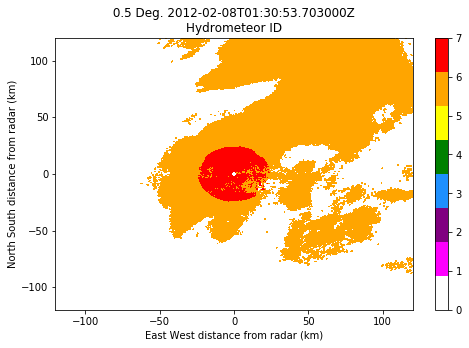

In [67]:
xlim = [-120,120]
ylim = [-120,120]
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(8,5))
display.plot_ppi('FHW', sweep=0, vmin=0, vmax=7, cmap=cmaphidwinter, 
                 colorbar_label='', mask_outside=True)
display.set_limits(xlim=xlim, ylim=ylim)


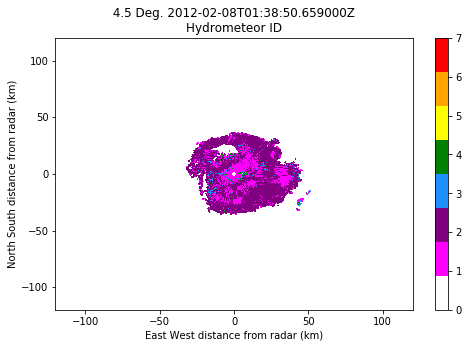

In [68]:
xlim = [-120,120]
ylim = [-120,120]
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(8,5))
display.plot_ppi('FHC', sweep=6, vmin=0, vmax=7, cmap=cmaphidwinter, 
                 colorbar_label='', mask_outside=True)
display.set_limits(xlim=xlim, ylim=ylim)



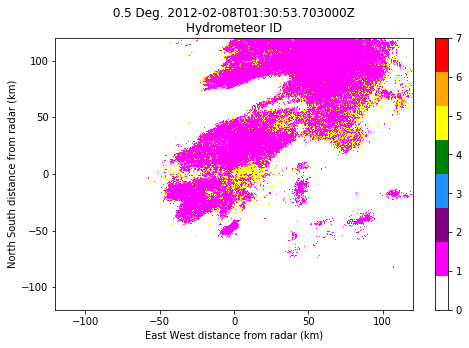

In [69]:
xlim = [-120,120]
ylim = [-120,120]
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(8,5))
display.plot_ppi('FHML', sweep=0, vmin=0, vmax=7, cmap=cmaphidwinter, 
                 colorbar_label='', mask_outside=True)
display.set_limits(xlim=xlim, ylim=ylim)



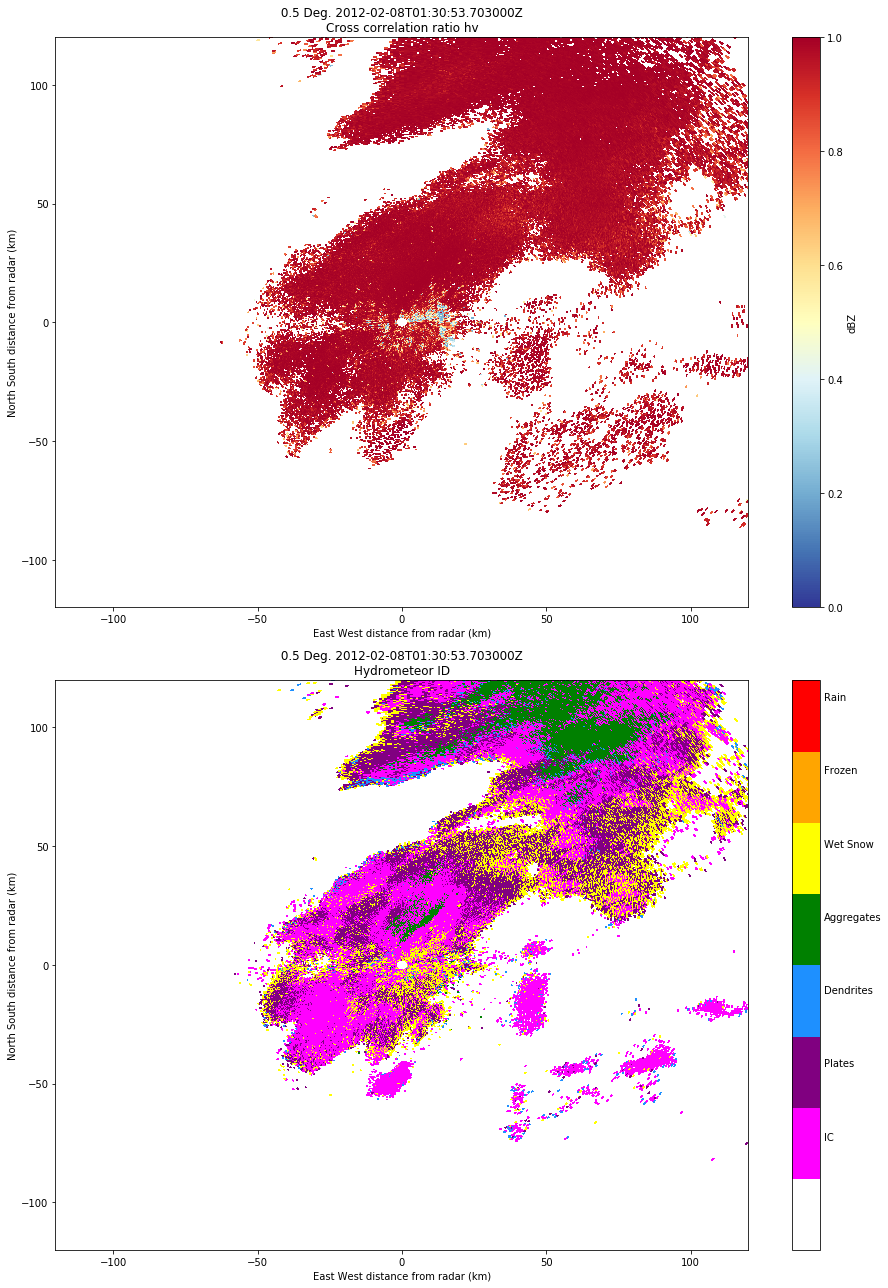

In [70]:
fig, ax1, ax2, display = two_panel_plot(
    radar, sweep=0, var1='cross_correlation_ratio', vmin1=0.0,vmax1=1.0,var2='FH', vmin2=0, vmax2=7,
    cmap2=cmaphidwinter, units2='', return_flag=True, xlim=xlim, ylim=ylim)
display.cbs[1] = adjust_fhcw_colorbar_for_pyart(display.cbs[1])
plt.tight_layout()
plt.savefig('{r}_winterHCA_{t}_example.png'.format(r=radsite,t=radar_start_date),dpi=200)

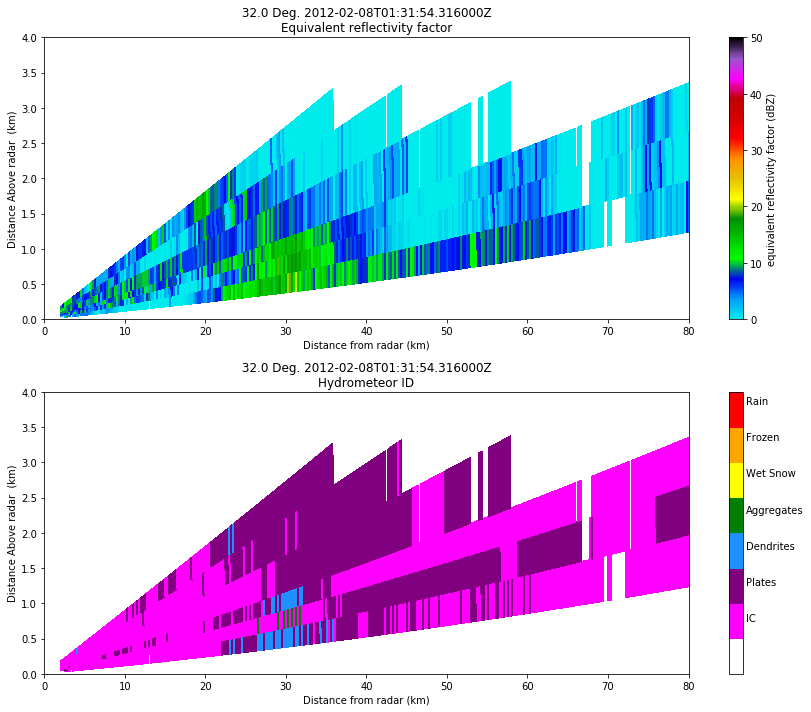

In [71]:
xsect = pyart.util.cross_section_ppi(radar, [32, 90])

display = pyart.graph.RadarDisplay(xsect)
fig = plt.figure(figsize=[12,10])
ax = fig.add_subplot(211)
display.plot('reflectivity', 0, vmin=0, vmax=50)
display.set_limits([0,80],[0,4])
ax = fig.add_subplot(212)
display.plot('FHC', 0, vmin=0, vmax=7,cmap=cmaphidwinter)
plt.tight_layout()
display.set_limits([0,80],[0,4])
display.cbs[1] = adjust_fhcw_colorbar_for_pyart(display.cbs[1])




In [ ]:
from csu_fhc_melt import melting_layer

In [ ]:
meltlev,melt_z,fh,scores_ML = melting_layer(dz=dz,zdr=dr,kdp=kd,rho=rh,sn=sn,heights=heights/1000.,scan_type = radar.scan_type,verbose=True,
    band='C', fdir='/Users/bdolan/scratch/WINTER_HCA/beta_function_parameters/',sn_thresh=10,nsect=36,azimuths=azimuths)



In [ ]:
print np.shape(melt_z)

In [ ]:
plt.plot(np.linspace(0,360,35),melt_z)